In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, confusion_matrix, recall_score, \
    accuracy_score, precision_score, f1_score, plot_confusion_matrix, classification_report, log_loss

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
pd.set_option('display.max_columns', None)

In [2]:
# Creating the class that will store my data

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss'])
    
    def __init__(self, name, model, X_train, X_test, y_train, y_test):
        self.name = name
        self.model = model
        self.params = model.get_params
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Collection of training attributes
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision_macro', 'accuracy', 'recall_macro', 'f1_macro', 'neg_log_loss'], n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision_macro'])
        self.train_rec = np.mean(self.train_results['test_recall_macro'])
        self.train_f1 = np.mean(self.train_results['test_f1_macro'])
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)  # accuracy
        self.y_pred = self.model.predict(self.X_test)
        
        self.test_score = model.score(self.X_test, self.y_test)
        self.test_recall = recall_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        self.test_prec = precision_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='macro', zero_division=0)
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
    
    def __repr__(self):
      return f"Model name: ({self.model})"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

# Data Imports

In [4]:
# Open the csv file, print its shape, and examine the first 5 rows of data
original_features_df = pd.read_csv('../Data/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
print(original_features_df.shape)
original_features_df.head()

(59400, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
df = pd.read_csv('../Data/updated_features.csv', index_col=0)

In [6]:
df.head(2)

,amount_tsh,funder,gps_height,installer,basin,subvillage,region_code,district_code,lga,population,public_meeting,scheme_management,permit,construction_year,extraction_type,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,dates_passed,Target,ward,scheme_name
0,6000.0,Roman,1390,Roman,Lake Nyasa,Other,11,5,Ludewa,109.0,True,VWC,False,1999.0,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,995,0,other,Roman
1,NaN,other,1399,other,Lake Victoria,Other,20,2,Serengeti,280.0,NaN,Other,True,2010.0,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,272,0,Natta,NaN


In [7]:
# sns.pairplot(df.select_dtypes(include=np.number))

# Breaking data into Train/Test split, smaller sample

In [8]:
# Create the smaller data set to be used in grid searches
sample_data = df.sample(5000, random_state=42)

In [9]:
X_sample = sample_data.drop("Target", axis = 1)
y_sample = sample_data['Target']

In [10]:
# Train/test split on the data
X = df.drop("Target", axis = 1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Pipelines for iterating over

In [11]:
# Create Pipelines for numeric and categorical data

subpipe_numerics = Pipeline(steps=[
    ('mean_impute', SimpleImputer(add_indicator=True, strategy='mean')),
    ('ss', StandardScaler()),
], verbose=True)

sub_pipe_cat = Pipeline(steps=[
    
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=True))  
], verbose=True)

In [12]:
# Create a column transformer to implement the above sub-pipelines

CT = ColumnTransformer(transformers=[
    ('subpipe_numerics', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', sub_pipe_cat, selector(dtype_include=object))
], remainder='passthrough', n_jobs= 4, verbose=True)

# Dummy Model

In [13]:
# Create the final pipeline for model instantiation.
dummy_model = Pipeline(steps=[
    ('CT', CT),
    ('dummy', DummyClassifier(strategy="most_frequent"))
], verbose=True)

# Baseline Logistic Model

In [14]:
lbfgs = Pipeline(steps=[
    ('CT', CT),
    ('baseline_log', LogisticRegression(C=.01, max_iter=1000, solver='lbfgs', verbose=1, n_jobs=4))
], verbose=True)

# Grid Search

In [16]:
# Establishing a starting dictionary of parameters and optional values
parameters = {
    "baseline_log__penalty": ["l1", "l2"],
    "baseline_log__tol": [.0001, .001, .01],
    "baseline_log__C": [1, .1, .01],
    "baseline_log__fit_intercept": [True, False],
    "baseline_log__solver": ['newton-cg', 'sag', 'lbfgs'],
    "baseline_log__max_iter": [100, 250, 500]
}

In [17]:
grid_search = GridSearchCV(
    estimator=#baseline_logistic,
    param_grid=parameters,
    n_jobs=4,
    cv=5,
    verbose=2)

NameError: name 'baseline_logistic' is not defined

# Smote Model

In [18]:
smote_dict = ImPipeline(steps=[
    ("CT", CT),
    ("smote", SMOTE(n_jobs= 4, sampling_strategy={0:24161,1:15000,2: 17146})),  
    # auto is both default and equivalent to 'not_majority'
    
    ('baseline_log', LogisticRegression(verbose=1, n_jobs=4)), 
    # using the same hyper-parameters as baseline/best model
], verbose= True)

In [19]:
smote_dict.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 3) Processing CT, total=   9.7s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   0.9s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.5s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   3.6s


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fae0a502250>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                   

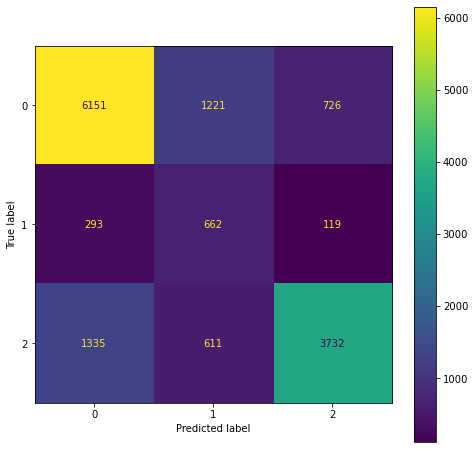

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(smote_dict, X_test, y_test, ax=ax);

In [22]:
y_test.value_counts()

0    8098
2    5678
1    1074
Name: Target, dtype: int64

In [17]:
# a reference for the previous models
previous_models_df = pd.read_csv('/Users/samalainabayeva/Desktop/Water Project CSVs/abridged_table.csv')
second_previous = pd.read_csv('/Users/samalainabayeva/Desktop/Water Project CSVs/2nd_add_table.csv')

# Model Iterations

In [65]:
smote_dict.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 3) Processing CT, total=   9.0s
[Pipeline] ............. (step 2 of 3) Processing smote, total=   1.7s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.2s finished


[Pipeline] ...... (step 3 of 3) Processing baseline_log, total=   5.3s


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f82e87f5820>),
                                                 ('sub...
                                      

In [34]:
grid_search.best_params_

{'baseline_log__C': 1,
 'baseline_log__fit_intercept': True,
 'baseline_log__max_iter': 100,
 'baseline_log__penalty': 'l2',
 'baseline_log__solver': 'sag',
 'baseline_log__tol': 0.0001}

In [25]:
grid_log = grid_search.best_estimator_.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing CT, total=   8.6s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 5 seconds
[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   5.0s


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.0s finished


# Model Instantion/variable storage

In [66]:
# Cell to contain the names/hyperparameters of models

# X_train, X_test, y_train, y_test  # for quick copy and paste

# dummy_model: 'dummy', DummyClassifier(strategy="most_frequent"
# dummy = Model("dummy", dummy_model, X_train, X_test, y_train, y_test)

# baseline_logistic 'baseline_log', LogisticRegression(verbose=1, n_jobs=4
# baseline = Model("baseline_log", baseline_logistic, X_train, X_test, y_train, y_test)

# 'baseline_log__C': 1, 'baseline_log__fit_intercept': True, 'baseline_log__max_iter': 100,'baseline_log__penalty': 'l2',
# 'baseline_log__solver': 'sag', 'baseline_log__tol': 0.0001
# gridsearch1 = Model("gridsearch1", grid_log, X_train, X_test, y_train, y_test)

# ("smote", SMOTE(n_jobs= 4, sampling_strategy='auto')
# smote1 = Model("smote1", smote_pipeline, X_train, X_test, y_train, y_test)

# ('baseline_log', LogisticRegression(C=.01, max_iter=200, solver='newton-cg', verbose=1, n_jobs=4)
# log2 = Model("logistic2", logistic2, X_train, X_test, y_train, y_test)

# poly_int -> same as above, polynomial interaction only
# interactions = Model("int_only", poly_int, X_train, X_test, y_train, y_test)

# poly2 -> now with degree two
# degree2 = Model("poly_deg_2", poly2, X_train, X_test, y_train, y_test)

# (no poly ->'baseline_log', LogisticRegression(C=.01, max_iter=1000, solver='newton-cg', verbose=1, n_jobs=4))
# max_i = Model("max_i_1000", max_iter, X_train, X_test, y_train, y_test)

# lbfgs -> same as above but different solver
# lbfgs = Model("lbfgs", lbfgs, X_train, X_test, y_train, y_test)

# ("smote", SMOTE(n_jobs= 4, sampling_strategy={0:24161,1:12000,2: 17146})
# smote_d = Model("smote_dict1", smote_dict, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  3.9min finished


# DataFrame Updates

In [67]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss
0,dummy,0.542334,0.180778,0.333333,0.234421,15.807208,0.545320,0.181773,0.333333,0.235257,15.704096
1,baseline_log,0.763098,0.700565,0.591662,0.613699,0.577305,0.763636,0.697416,0.592629,0.614711,0.571270
2,gridsearch1,0.761571,0.719763,0.575277,0.594477,0.586064,0.763098,0.708619,0.574679,0.592508,0.580114
3,smote1,0.675578,0.607805,0.680058,0.602763,0.720017,0.671111,0.608147,0.684890,0.600826,0.716779
4,logistic2,0.748979,0.721377,0.540635,0.545412,0.614213,0.751313,0.711600,0.544614,0.552147,0.607817
5,int_only,0.749585,0.725608,0.543306,0.549996,0.611666,0.751380,0.720979,0.546715,0.555686,0.605992
6,poly_deg_2,0.749585,0.725608,0.543306,0.549996,0.611666,0.751380,0.720979,0.546715,0.555686,0.605992
7,max_i_1000,0.749585,0.725608,0.543306,0.549996,0.611666,0.751380,0.720979,0.546715,0.555686,0.605992
8,lbfgs,0.749562,0.725586,0.543292,0.549981,0.611663,0.751380,0.720979,0.546715,0.555686,0.605992
9,smote_dict1,0.707003,0.620109,0.670849,0.621051,0.671317,0.708822,0.621274,0.673983,0.622540,0.662777


After failing to improve upon the baseline Logistic Regression, I determined that grid searching multiple 5k samples to determine the best hyper-parameters would be the best course of action.

In [68]:
for i in baseline_logistic.get_params().keys():
    print(i)

memory
steps
verbose
CT
baseline_log
CT__n_jobs
CT__remainder
CT__sparse_threshold
CT__transformer_weights
CT__transformers
CT__verbose
CT__subpipe_numerics
CT__subpipe_cat
CT__subpipe_numerics__memory
CT__subpipe_numerics__steps
CT__subpipe_numerics__verbose
CT__subpipe_numerics__mean_impute
CT__subpipe_numerics__ss
CT__subpipe_numerics__mean_impute__add_indicator
CT__subpipe_numerics__mean_impute__copy
CT__subpipe_numerics__mean_impute__fill_value
CT__subpipe_numerics__mean_impute__missing_values
CT__subpipe_numerics__mean_impute__strategy
CT__subpipe_numerics__mean_impute__verbose
CT__subpipe_numerics__ss__copy
CT__subpipe_numerics__ss__with_mean
CT__subpipe_numerics__ss__with_std
CT__subpipe_cat__memory
CT__subpipe_cat__steps
CT__subpipe_cat__verbose
CT__subpipe_cat__cat_impute
CT__subpipe_cat__ohe
CT__subpipe_cat__cat_impute__add_indicator
CT__subpipe_cat__cat_impute__copy
CT__subpipe_cat__cat_impute__fill_value
CT__subpipe_cat__cat_impute__missing_values
CT__subpipe_cat__cat_impu

In [70]:
# Establishing a starting dictionary of parameters and optional values
parameters = {
    "baseline_log__tol": [.0001, .001, .01],
    "baseline_log__C": [1, .1, .01],
    "baseline_log__fit_intercept": [True, False],
    "baseline_log__solver": ['newton-cg', 'sag', 'lbfgs'],
    "baseline_log__max_iter": [100, 250, 500, 1000, 2000]
}

In [71]:
5*3*2*3*3*5

1350

In [78]:
grid_search1 = GridSearchCV(
    estimator=baseline_logistic,
    param_grid=parameters,
    n_jobs=4,
    cv=5,
    verbose=2)

# Begin Final Grid Searching

In [79]:
grid_search1.fit(X_sample, y_sample)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 1350 out of 1350 | elapsed:  5.3min finished


[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.2s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 0 seconds
[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   0.4s


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(n_jobs=4,
                                                          remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('mean_impute',
                                                                                          SimpleImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())],
                                                                                  verbose=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f83f2e05490>)

In [81]:
grid_search1.best_params_

{'baseline_log__C': 1,
 'baseline_log__fit_intercept': True,
 'baseline_log__max_iter': 100,
 'baseline_log__solver': 'sag',
 'baseline_log__tol': 0.0001}

# Final Grid Search 2

In [82]:
sample_data2 = df.sample(5000, random_state=13)

In [83]:
grid_search2 = GridSearchCV(
    estimator=baseline_logistic,
    param_grid=parameters,
    n_jobs=4,
    cv=5,
    verbose=2)

In [84]:
X_2 = sample_data2.drop("Target", axis= 1)
y_2 = sample_data2['Target']

grid_search2.fit(X_2, y_2)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   56.5s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 1350 out of 1350 | elapsed:  5.2min finished


[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.2s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 0 seconds
[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   0.5s


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(n_jobs=4,
                                                          remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('mean_impute',
                                                                                          SimpleImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())],
                                                                                  verbose=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f83f2e05490>)

In [85]:
grid_search2.best_params_

{'baseline_log__C': 1,
 'baseline_log__fit_intercept': True,
 'baseline_log__max_iter': 100,
 'baseline_log__solver': 'sag',
 'baseline_log__tol': 0.001}

# Final Grid Search 3

In [86]:
grid_search3 = GridSearchCV(
    estimator=baseline_logistic,
    param_grid=parameters,
    n_jobs=4,
    cv=5,
    verbose=2)

In [87]:
sample_data3 = df.sample(5000, random_state=23)

In [88]:
X_3 = sample_data3.drop("Target", axis=1) 
y_3 = sample_data3['Target']

grid_search3.fit(X_3, y_3)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   55.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 1350 out of 1350 | elapsed:  4.6min finished


[Pipeline] ................ (step 1 of 2) Processing CT, total=   0.2s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.8s finished


[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   0.9s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(n_jobs=4,
                                                          remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('mean_impute',
                                                                                          SimpleImputer(add_indicator=True)),
                                                                                         ('ss',
                                                                                          StandardScaler())],
                                                                                  verbose=True),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f83f2e05490>)

In [81]:
grid_search1.best_params_

{'baseline_log__C': 1,
 'baseline_log__fit_intercept': True,
 'baseline_log__max_iter': 100,
 'baseline_log__solver': 'sag',
 'baseline_log__tol': 0.0001}

In [85]:
grid_search2.best_params_

{'baseline_log__C': 1,
 'baseline_log__fit_intercept': True,
 'baseline_log__max_iter': 100,
 'baseline_log__solver': 'sag',
 'baseline_log__tol': 0.001}

In [89]:
grid_search3.best_params_

{'baseline_log__C': 0.1,
 'baseline_log__fit_intercept': True,
 'baseline_log__max_iter': 100,
 'baseline_log__solver': 'newton-cg',
 'baseline_log__tol': 0.0001}

So there is very consistent agreement on the max_iters = 100 and fit_intercept = True. 
- C 2-to-1 = 1
- Solver 2-to-1 = 'sag'
- tolerance 2-to-1 = 0.0001

So the final model would be:

In [90]:
# final_model = LogisticRegression(C=1, tol=0.0001, fit_intercept=True, solver='sag', max_iter=100, n_jobs=4)

In [92]:
final_model = Pipeline(steps=[
    ('CT', CT),
    ('baseline_log', LogisticRegression(C=1, tol=0.0001, fit_intercept=True, solver='sag', max_iter=100, n_jobs=4, 
                                       verbose=1))
], verbose=True)

In [93]:
final_model.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 2) Processing CT, total=   9.5s


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 8 seconds
[Pipeline] ...... (step 2 of 2) Processing baseline_log, total=   8.2s


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    8.2s finished


Pipeline(steps=[('CT',
                 ColumnTransformer(n_jobs=4, remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('mean_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))],
                                                           verbose=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f82e87f5820>),
                                                 ('subpipe_cat',
                               

In [94]:
final = Model("final_model", final_model, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   25.0s finished


In [95]:
Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss
0,dummy,0.542334,0.180778,0.333333,0.234421,15.807208,0.545320,0.181773,0.333333,0.235257,15.704096
1,baseline_log,0.763098,0.700565,0.591662,0.613699,0.577305,0.763636,0.697416,0.592629,0.614711,0.571270
2,gridsearch1,0.761571,0.719763,0.575277,0.594477,0.586064,0.763098,0.708619,0.574679,0.592508,0.580114
3,smote1,0.675578,0.607805,0.680058,0.602763,0.720017,0.671111,0.608147,0.684890,0.600826,0.716779
4,logistic2,0.748979,0.721377,0.540635,0.545412,0.614213,0.751313,0.711600,0.544614,0.552147,0.607817
5,int_only,0.749585,0.725608,0.543306,0.549996,0.611666,0.751380,0.720979,0.546715,0.555686,0.605992
6,poly_deg_2,0.749585,0.725608,0.543306,0.549996,0.611666,0.751380,0.720979,0.546715,0.555686,0.605992
7,max_i_1000,0.749585,0.725608,0.543306,0.549996,0.611666,0.751380,0.720979,0.546715,0.555686,0.605992
8,lbfgs,0.749562,0.725586,0.543292,0.549981,0.611663,0.751380,0.720979,0.546715,0.555686,0.605992
9,smote_dict1,0.707003,0.620109,0.670849,0.621051,0.671317,0.708822,0.621274,0.673983,0.622540,0.662777


After grid searching for optimized hyperparameters, the best performing model was still the baseline logistic regression without any kind of tweaking whatsoever.

In [96]:
Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Water Project CSVs/final_metrics_table.csv')

# Prior DataFrames

In [15]:
second_previous

,Unnamed: 0,Name,train_score,train_log_loss,test_score,test_log_loss,name,test_accuracy,test_f1,test_logloss,test_prec,test_recall,train_accuracy,train_f1,train_logloss,train_prec,train_recall
0,0,dummy,0.542334,15.807208,0.545320,15.704096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,logistic_1,0.771762,0.577305,0.763636,0.598705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,grid_logistic_1,0.766981,0.586082,0.763030,0.596011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,smote_1,0.683659,0.720839,0.669091,0.733580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,lr_C.01_mi200_solv_n.cg,0.753378,0.614420,0.750976,0.642552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,c.01_mi200_svr_ncg_tol_1,0.677621,0.747923,0.668215,0.773572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,poly1_lr_C.01_mi200_solv_n.cg,0.753378,0.614420,0.750976,0.642552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,poly2_lr_C.01_mi1000_solv_n.cg,0.753378,0.614420,0.750976,0.642552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,saga_l1_mi1000,0.727452,0.663176,0.728013,0.699459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,lbfgs,0.753378,0.614422,0.750909,0.642552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
previous_models_df

,Unnamed: 0,Name,train_score,test_score
0,0,0,0.000000,0.000000
1,0,baseline,0.669742,0.665051
2,0,Smote_grid1,0.669742,0.665051
3,0,Baseline_log,0.769921,0.765051
4,0,Baseline_log,0.769921,0.765051
5,0,Baseline_log_grid,0.766846,0.764781
6,0,poly1,0.772435,0.768822
7,0,Poly_grid_1,0.772435,0.768822
8,0,poly2,0.770168,0.766128
9,0,Poly_grid_3,0.772435,0.768822


# Observations:
- Changing sampling strategy to "auto" made no difference in SMOTE hyperparameters.
- Baseline log grid slightly worse than the uncalibrated logistic regression
- For polynomial features, the grid search did not improve the default settings at all, still not overfit
- After a 2 hour grid search, the best model only equals the best score thus far, still without overfitting, but without any improvement either.
- Polynomial degree 2 + smote improved upon the baseline smote, but still performed worse than other models

- Adding the dates_passed column improved the model very slightly. I will now re-check cleaning/feature selection.
#### Returning to the baseline logistic regression model and modifying from there
- Baseline Logistic Regression continues to be the best model
- StandardScaler and MinMaxScaler produced the same exact results
- Median fill and mean fill produced identical results